In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv', index_col=0)
df.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
id,,,,,,,,,,,
0,60,Male,2.9,1.3,170.9,42.1,37.1,5.5,2.9,1.01,1
1,28,Female,0.7,0.1,158.8,26.0,23.9,6.4,3.7,1.36,0
2,60,Male,23.1,12.5,962.0,53.0,40.9,6.8,3.3,0.96,1
3,20,Male,1.0,0.5,415.9,33.9,39.0,7.0,3.8,1.31,0
4,44,Female,0.6,0.3,152.9,40.9,42.0,4.5,2.1,1.04,0


In [3]:
df.isnull().sum()

Age         0
Gender      0
T_Bil       0
D_Bil       0
ALP         0
ALT_GPT     0
AST_GOT     0
TP          0
Alb         0
AG_ratio    4
disease     0
dtype: int64

In [4]:
# AG_ratioに欠測値あり。平均値で補っていく。
df['AG_ratio'] = df['AG_ratio'].fillna(df['AG_ratio'].mean())

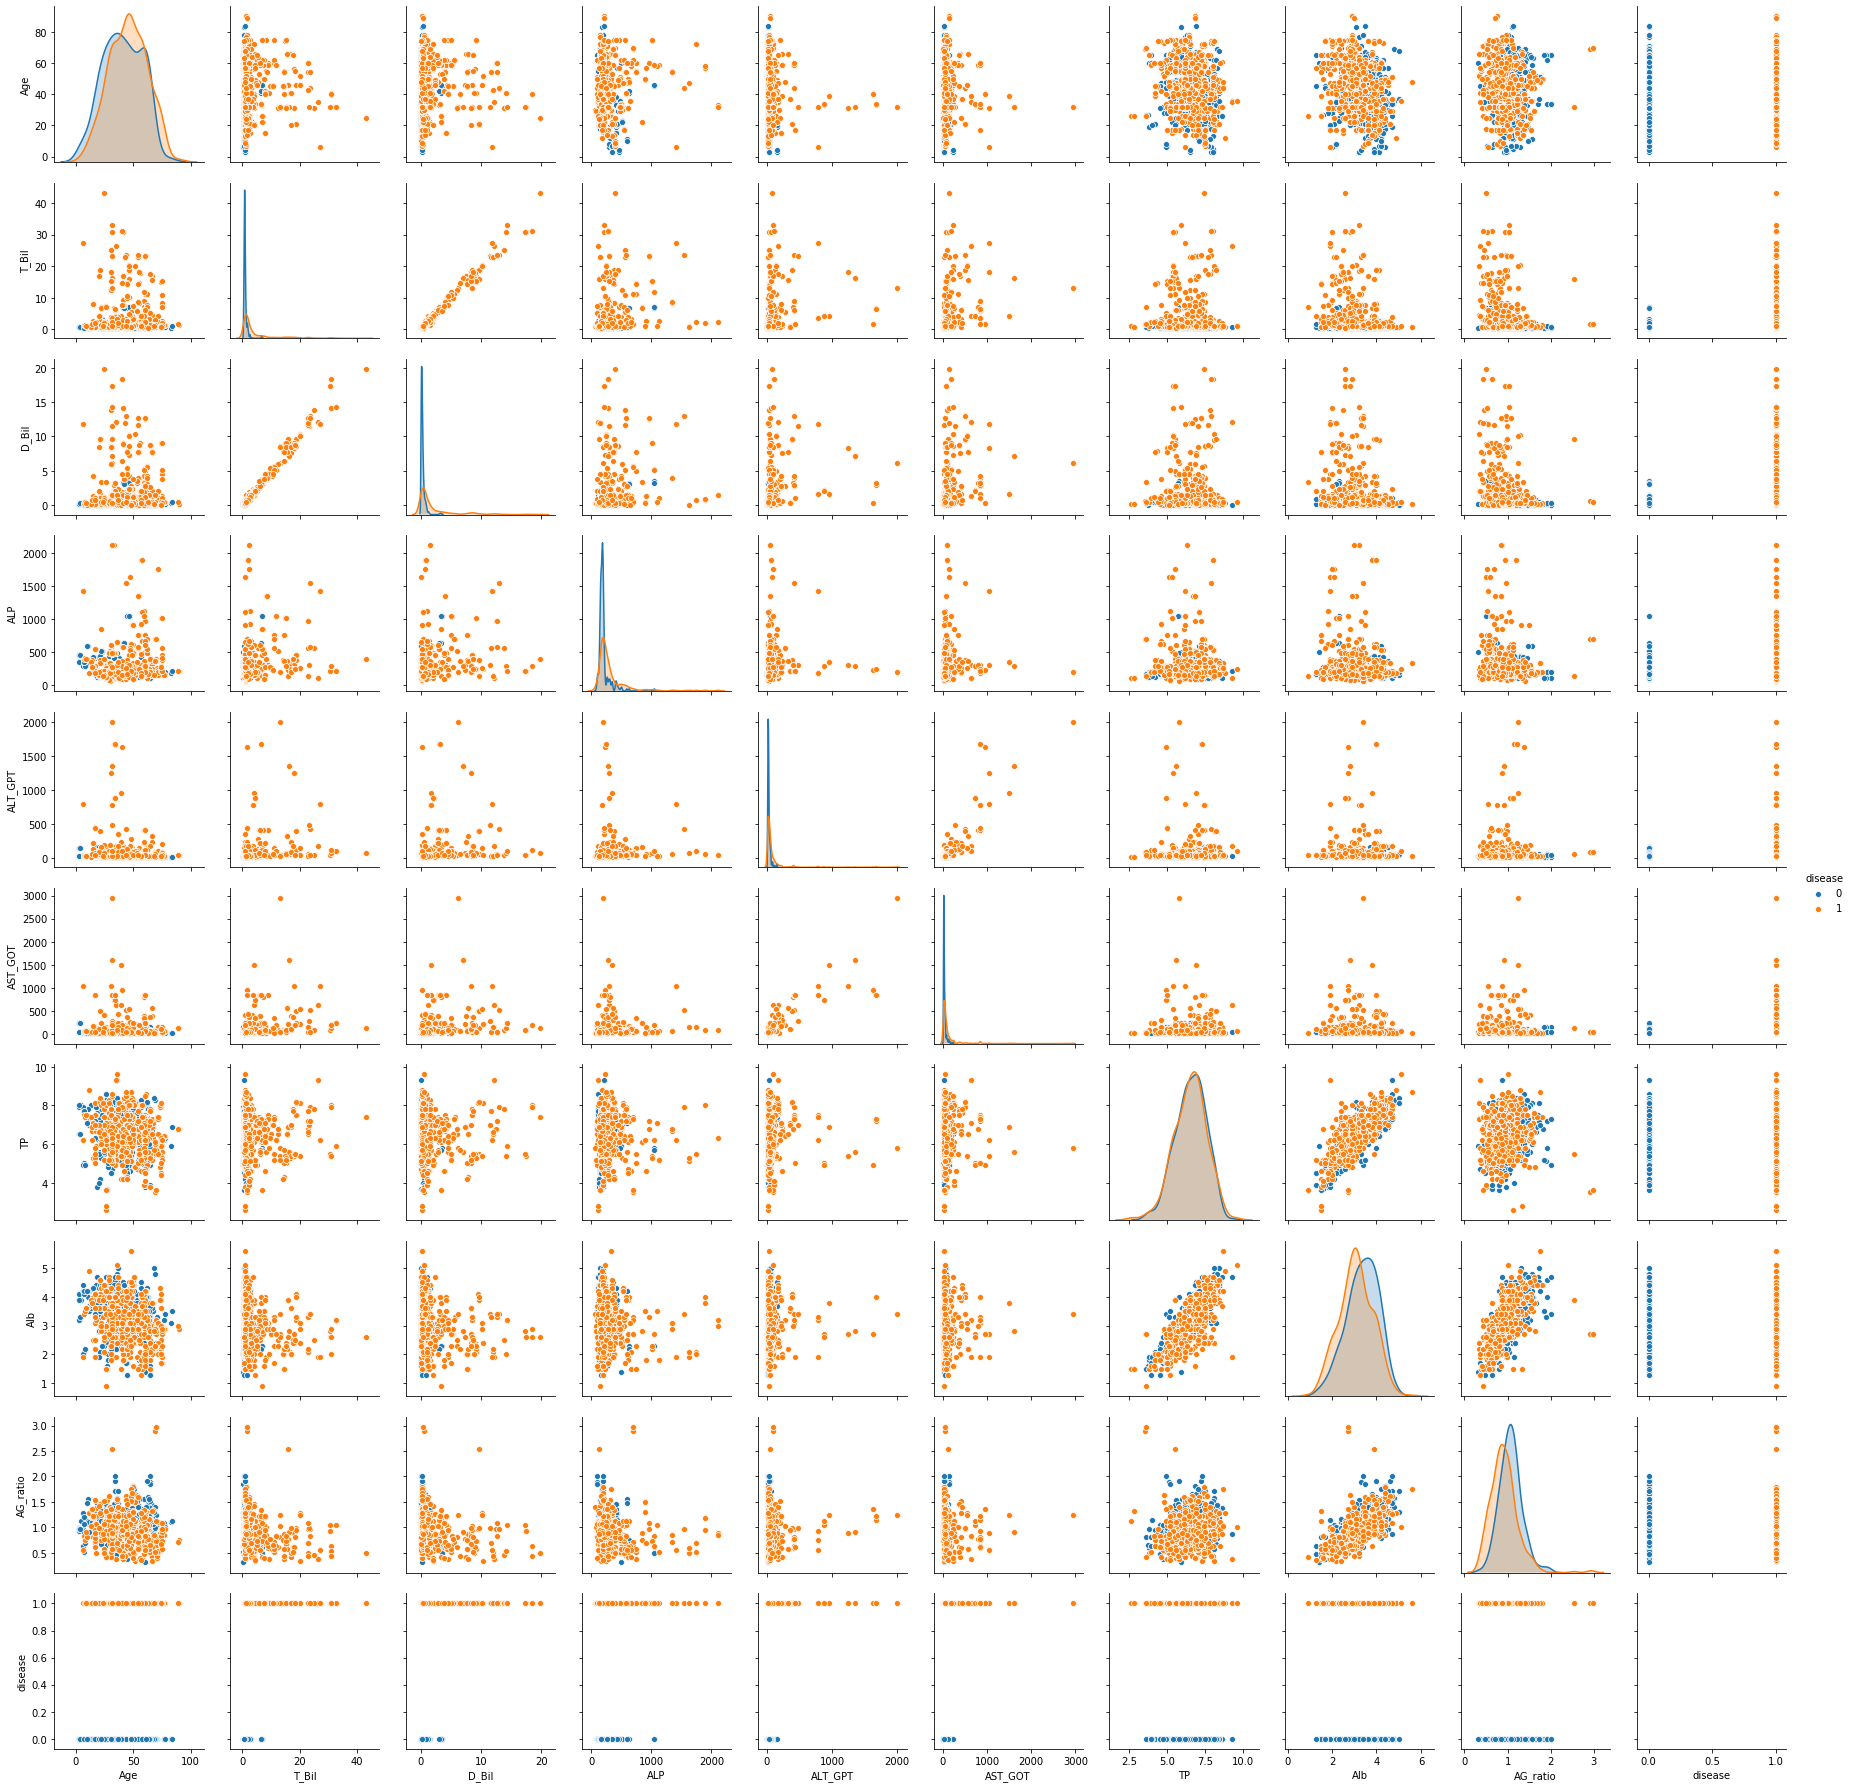

In [6]:
# pair plot
sns.pairplot(df[:-1], hue='disease')

In [7]:
# Genderの列がカテゴリーのため、数値に置換する。今回Genderは2変数なので、ワンホットエンコーディングを行わず。
# いったん数字で変換する。
df = df.replace('Male', 0)
df = df.replace('Female', 1)
df.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
id,,,,,,,,,,,
0,60,0,2.9,1.3,170.9,42.1,37.1,5.5,2.9,1.01,1
1,28,1,0.7,0.1,158.8,26.0,23.9,6.4,3.7,1.36,0
2,60,0,23.1,12.5,962.0,53.0,40.9,6.8,3.3,0.96,1
3,20,0,1.0,0.5,415.9,33.9,39.0,7.0,3.8,1.31,0
4,44,1,0.6,0.3,152.9,40.9,42.0,4.5,2.1,1.04,0


In [8]:
# テストデータの分割 テストサイズはデフォルトの0.25
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [18]:
from sklearn.neighbors import KNeighborsClassifier # k近傍
from sklearn.linear_model import LogisticRegression # ロジスティック回帰
from sklearn.tree import DecisionTreeClassifier # 決定木
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier # ランダムフォレスト, 勾配ブースティング
from sklearn.svm import SVC # カーネルトリック

In [19]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("KNeighborsClassifier")
print("Train score {}".format(knn.score(X_train, y_train)))
print("Test score {}".format(knn.score(X_test, y_test)))
logreg = LogisticRegression(solver='lbfgs', max_iter=1000000, random_state=0)
logreg.fit(X_train, y_train)
print("LogisticRegression")
print("Train score {}".format(logreg.score(X_train, y_train)))
print("Test score {}".format(logreg.score(X_test, y_test)))
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)
print("Tree decision")
print("Train score {}".format(tree.score(X_train, y_train)))
print("Test score {}".format(tree.score(X_test, y_test)))
forest = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=4)
forest.fit(X_train, y_train)
print("RandomForest")
print("Train score {}".format(forest.score(X_train, y_train)))
print("Test score {}".format(forest.score(X_test, y_test)))
gbrt = GradientBoostingClassifier(random_state=0, max_depth=3)
gbrt.fit(X_train, y_train)
print("GradientBoosting")
print("Train score {}".format(gbrt.score(X_train, y_train)))
print("Test score {}".format(gbrt.score(X_test, y_test)))
svm = SVC(gamma=0.1)
svm.fit(X_train, y_train)
print("SVM")
print("Train score {}".format(svm.score(X_train, y_train)))
print("Test score {}".format(svm.score(X_test, y_test))) # SVMが優秀そう

KNeighborsClassifier
Train score 0.9266467065868264
Test score 0.8116591928251121
LogisticRegression
Train score 0.7784431137724551
Test score 0.757847533632287
Tree decision
Train score 0.8517964071856288
Test score 0.7713004484304933
RandomForest
Train score 0.8622754491017964
Test score 0.7802690582959642
GradientBoosting
Train score 0.9610778443113772
Test score 0.8251121076233184
SVM
Train score 1.0
Test score 0.9147982062780269


In [26]:
# SVMのパラメーターを最適化する。
best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # それぞれのパラメータの組み合わせに対して
        # SVCを訓練する→交差検証
        svm = SVC(gamma=gamma, C=C)
        scores = cross_val_score(svm, X, y, cv=5)
        score = np.mean(scores)
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
svm = SVC(**best_parameters)
svm.fit(X_train, y_train)
print("best parameters:{}".format(best_parameters)) # ベストパラメーターはC=10, gamma=0.01
print("Train score {}".format(svm.score(X_train, y_train)))
print("Test score {}".format(svm.score(X_test, y_test)))

best parameters:{'C': 10, 'gamma': 0.01}
Train score 0.9985029940119761
Test score 0.9237668161434978


In [27]:
# test dataに関しても同様の処理を行う。
test_df = pd.read_csv('test.csv', index_col=0)
test_df = test_df.replace('Male', 0)
test_df = test_df.replace('Female', 1)
test_df.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
id,,,,,,,,,,
891,65,1,0.7,0.2,162.0,24.0,20.0,6.4,3.3,0.93
892,46,0,1.2,0.3,265.1,40.0,28.0,7.9,3.8,0.94
893,26,0,0.7,0.1,243.1,21.1,22.9,5.3,2.2,0.60
894,38,0,3.5,1.7,253.0,80.0,406.0,6.8,3.7,1.33
895,46,1,0.7,0.2,236.0,10.1,13.0,6.8,3.0,0.74


In [ ]:
X_test = test_df.values
prediction = svm.predict(X_test)
predict_df = pd.DataFrame([test_df.index, prediction]).T
